In [1]:
import pandas as pd
import numpy as np

In [2]:
#df = pd.read_json(r"../data/df_final_para.json") # paragraphs - 3776
df = pd.read_json(r"../data/df_final_document.json") # document - 143 entries

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 187
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Reference                     143 non-null    object
 1   Feedback date                 143 non-null    object
 2   User type                     112 non-null    object
 3   Scope                         4 non-null      object
 4   Organisation name             112 non-null    object
 5   Transparency register number  93 non-null     object
 6   Organisation size             112 non-null    object
 7   label_132                     143 non-null    object
 8   label_134                     143 non-null    object
 9   submit                        143 non-null    int64 
 10  file_name                     73 non-null     object
 11  language                      143 non-null    object
 12  text                          143 non-null    object
 13  text_clean          

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label.132'] = le.fit_transform(df['label_132'])
df['label.134'] = le.fit_transform(df['label_134'])

In [5]:
df['submit'].value_counts()

1    73
0    70
Name: submit, dtype: int64

In [6]:
#only use pdf submissions
df = df[df['submit']==1]

In [7]:
#df.sort_values(by='count', ascending=False)[['Reference', 'count']].head(10)

In [8]:
#pd.Series(df['count']).hist(bins = 50)

## BERT multi-classification (K=2) using Q132/label.132

References: 

https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/?

https://trishalaneeraj.github.io/2020-04-04/feature-based-approach-with-bert

In [9]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import yaml
import transformers
from transformers import AutoModel, BertTokenizerFast
from tqdm.notebook import tqdm

In [10]:
# specify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
# split data into train, test, validation sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text_clean'], df['label.132'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label.132'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [12]:
print(len(train_text))
print(len(val_text))
print(len(test_text))

51
11
11


Import BERT Model and BERT Tokenizer

In [13]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', return_dict=False)

In [15]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

In [16]:
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

In [17]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


Tokenize the Sentences

<AxesSubplot: >

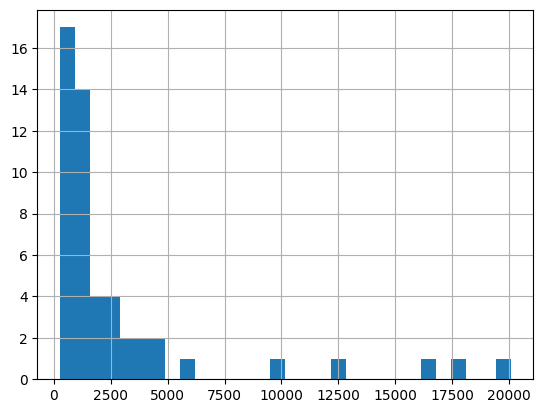

In [18]:
import matplotlib

# get length of all the messages in the train set
seq_len = [len(str(i).split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [19]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

c:\Users\admin\anaconda3\envs\watermelon\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [20]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [53]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 2
num_workers = 2

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# dataLoader for train set
train_dataloader = DataLoader(train_data, num_workers=num_workers, shuffle=True, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, num_workers=num_workers, shuffle=True, batch_size=batch_size)

Define Model Architecture

In [54]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [77]:
# method to freeze all the parameters if freeze = T
def set_parameter_requires_grad(model, freeze):
    if freeze:
        for param in model.parameters():
            param.requires_grad = False

In [78]:
# freeze all parameters
set_parameter_requires_grad(model=bert, freeze=True)

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [79]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

c:\Users\admin\anaconda3\envs\watermelon\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [80]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )

class_weights
print("Class Weights:",class_weights)

Class Weights: [1.0625     0.94444444]


In [81]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
criterion  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 20

In [114]:
for x, batch in enumerate(tqdm(train_dataloader)):
    print(batch)

  0%|          | 0/26 [00:00<?, ?it/s]

[tensor([[  101, 10093, 12879, 12356,  2050,  1521, 24501, 26029,  2015,  1040,
          2290,  4012,  2361,  1521, 23363,  7634,  2047,  4012, 22327,  4183,
          6994, 17419,  6633,  2497,   102],
        [  101, 25416,  2024,  5709,  1013,  5641,  1013, 12609, 10613,  1011,
          2522,  3351,  3540,  1053,  3501,  5354, 24087,  1024,  1016,  1011,
          1042,  2290,  1013, 15488,   102]]), tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1]]), tensor([1, 0])]
[tensor([[  101, 25416,  2024,  5641,  1013,  5641,  1013, 12609,  4962,  2099,
          5136,  2047,  7327,  4012, 22327,  4183,  6994, 12919,  4012, 22327,
          4183,  4372, 29278,  2278,   102],
        [  101, 13433, 28032,  3259, 17419,  6633,  2497,  4012, 15630,  2015,
         23363,  2047,  4012, 22327,  4183,  6994,  3145,  6752,  8490,  9944,
          9006,  5017, 

Fine-Tune BERT

In [115]:
# function to train the model
def train(model, dataloader, criterion, optimizer):
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  total_preds=[]
  
  # iterate over batches
  for i, batch  in enumerate(tqdm(dataloader)):
    
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = criterion(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # push model predictions to cpu
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds


In [116]:
# function for evaluating the model
def evaluate(model, dataloader, criterion):
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for i, batch in enumerate(tqdm(dataloader)):
    
    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = criterion(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [117]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train(model, train_dataloader, criterion, optimizer)
    
    #evaluate model
    valid_loss, _ = evaluate(model, val_dataloader, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'Training Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.685
Validation Loss: 0.689

 Epoch 2 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.697
Validation Loss: 0.684

 Epoch 3 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.689
Validation Loss: 0.684

 Epoch 4 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.667
Validation Loss: 0.680

 Epoch 5 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.670
Validation Loss: 0.691

 Epoch 6 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.681
Validation Loss: 0.681

 Epoch 7 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.681
Validation Loss: 0.690

 Epoch 8 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.684
Validation Loss: 0.681

 Epoch 9 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Training Loss: 0.681
Validation Loss: 0.689

 Epoch 10 / 20


  0%|          | 0/26 [00:00<?, ?it/s]

KeyboardInterrupt: 

Make predictions

In [30]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [34]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [35]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.71      0.83      0.77         6

    accuracy                           0.73        11
   macro avg       0.73      0.72      0.72        11
weighted avg       0.73      0.73      0.72        11



In [36]:
df['label.132'].value_counts()

1    39
0    34
Name: label.132, dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 1 to 181
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Reference                     73 non-null     object
 1   Feedback date                 73 non-null     object
 2   User type                     65 non-null     object
 3   Scope                         2 non-null      object
 4   Organisation name             65 non-null     object
 5   Transparency register number  52 non-null     object
 6   Organisation size             65 non-null     object
 7   label_132                     73 non-null     object
 8   label_134                     73 non-null     object
 9   submit                        73 non-null     int64 
 10  file_name                     73 non-null     object
 11  language                      73 non-null     object
 12  text                          73 non-null     object
 13  text_clean           

References for tf-idf word embeddings:

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html